In [ ]:
import sys, time, os, warnings 
from PIL import Image
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
from keras.applications.vgg16 import VGG16, preprocess_input
from datetime import datetime
from google.colab import files
import matplotlib.pyplot as plt
import random
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Download Flickr8k Dataset

In [ ]:
data_dir = "./data"

downloads_dir = data_dir + '/downloads'
datasets_dir = data_dir + '/datasets'
models_dir = data_dir + '/models'
pretrained_models = data_dir + '/pretrained_models'


os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(pretrained_models, exist_ok=True)

flickr_images_dir = datasets_dir + '/flickr_images_dataset'
flickr_captions_dir = datasets_dir + '/flickr_captions_dataset'

!wget https://www.dropbox.com/s/xcr5a8at65fbdo6/Flickr8k_Dataset.zip -O {downloads_dir}/Flickr8k_Dataset.zip
!wget https://www.dropbox.com/s/8nztpstsmguseik/Flickr8k_text.zip -O {downloads_dir}/Flickr8k_text.zip

!unzip -o {downloads_dir}'/Flickr8k_Dataset.zip' -d {flickr_images_dir}
!unzip -o {downloads_dir}'/Flickr8k_text.zip' -d {flickr_captions_dir}

flickr_images_dir += '/Flicker8k_Dataset/'

Streaming output truncated to the last 5000 lines.
  inflating: ./data/datasets/flickr_images_dataset/Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: ./data/datasets/flickr_images_dataset/__MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: ./data/datasets/flickr_images_dataset/Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: ./data/datasets/flickr_images_dataset/__MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: ./data/datasets/flickr_images_dataset/Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: ./data/datasets/flickr_images_dataset/__MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: ./data/datasets/flickr_images_dataset/Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: ./data/datasets/flickr_images_dataset/__MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: ./data/datasets/flickr_images_dataset/Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: ./data/datasets/fli

Read Captions from Text files and make Train/ Test Split

In [ ]:
def read_captions(path):
    captions = []
    with open(path, 'r') as file:
        for line in file:
            captions.append(line.strip())
    return captions
    
train_captions = read_captions(flickr_captions_dir + '/Flickr_8k.trainImages.txt')
test_captions = read_captions(flickr_captions_dir + '/Flickr_8k.testImages.txt')
test_captions += read_captions(flickr_captions_dir + '/Flickr_8k.devImages.txt')

Create a dataframe of image names and captions

In [ ]:
def create_caption_df(path):    
    df_list = []
    with open(path, 'r') as file:
        for line in file:
            line = line.split("\t")
            image_caption = line[0].split("#")
            image, caption = image_caption[0], image_caption[1]
            df_list.append({"Image":image, "CaptionNum": caption, "Caption": line[1]})
    df = pd.DataFrame(df_list)
    return df
df = create_caption_df(flickr_captions_dir + '/Flickr8k.lemma.token.txt')
train_captions = set(train_captions)
test_captions = set(test_captions)
df["split"] = None
for index, row in df.iterrows():
    if row['Image'] in train_captions:
        df.loc[index, "split"] = "Train"
    else:
        df.loc[index, "split"] = "Test"

# Remove invalid filenames
df = df[df['Image'].str.endswith("jpg")]
df['full_path'] = flickr_images_dir+df['Image']

<ipython-input-4-392f9396e5a2>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_path'] = flickr_images_dir+df['Image']


In [ ]:
uploaded = files.upload()
df = pd.read_csv('data.csv')
df

Saving data.csv to data.csv


,Image,CaptionNum,Caption,split,full_path
0,1305564994_00513f9a5b.jpg,0,<start> A man street racer armor examine tire ...,Train,./data/datasets/flickr_images_dataset/Flicker8...
1,1305564994_00513f9a5b.jpg,1,<start> Two racer drive white bike road <end>,Train,./data/datasets/flickr_images_dataset/Flicker8...
2,1305564994_00513f9a5b.jpg,2,<start> Two motorist ride along vehicle oddly ...,Train,./data/datasets/flickr_images_dataset/Flicker8...
3,1305564994_00513f9a5b.jpg,3,<start> Two person small race car drive green ...,Train,./data/datasets/flickr_images_dataset/Flicker8...
4,1305564994_00513f9a5b.jpg,4,<start> Two person race uniform street car <end>,Train,./data/datasets/flickr_images_dataset/Flicker8...
...,...,...,...,...,...
40450,989754491_7e53fb4586.jpg,0,<start> A girl pool wear goggles surround chil...,Test,./data/datasets/flickr_images_dataset/Flicker8...
40451,989754491_7e53fb4586.jpg,1,<start> A girl green goggles pool three child ...,Test,./data/datasets/flickr_images_dataset/Flicker8...
40452,989754491_7e53fb4586.jpg,2,<start> A red haired girl make peace sign wear...,Test,./data/datasets/flickr_images_dataset/Flicker8...
40453,989754491_7e53fb4586.jpg,3,<start> A redheaded girl offer peace sign swim...,Test,./data/datasets/flickr_images_dataset/Flicker8...


Create an Image Dataset by converting and preprocessing images as required by VGG16

In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)   
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path
image, _ = load_image(flickr_images_dir+df.Image[0])
plt.imshow(image)
image_dataset = tf.data.Dataset.from_tensor_slices(np.unique(df['full_path']))
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

Load VGG16 Model

In [ ]:
vgg_model = tf.keras.applications.VGG16(include_top=True,weights=None) 
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Make VGG16 Headless to get features from the model

In [ ]:
feature_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
input = feature_model.input 
hidden_layer = feature_model.layers[-1].output
feature_model = tf.keras.Model(input, hidden_layer)
feature_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

Convert Image to VGG16 Features and save them as numpy arrays

In [ ]:
for img, path in tqdm(image_dataset):
    batch_features = feature_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [02:21<00:00,  1.12s/it]


Preprocess Captions

In [ ]:
# Remove punctuations from captions
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
df["Caption"] = df['Caption'].apply(remove_punctuations)
# Remove stopwords
stop = stopwords.words('english')
df['Caption'] = df['Caption'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# Add start and end tag
df['Caption'] = '<start> '+df['Caption'] + " <end>"

Tokenize Captions into Sequences

In [ ]:
def tokenize_caption(top_k,train_captions):
  # Choose the top 5000 words from the vocabulary
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls  
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  # Map '<pad>' to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'
  # Create the tokenized vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_captions = df[df['split']=='Train']['Caption']
train_seqs, tokenizer = tokenize_caption(5000,train_captions)
test_captions = df[df['split']=='Test']['Caption']
test_seqs = tokenizer.texts_to_sequences(test_captions)

Make Captions of Fixed Length by Padding

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

def padding_sequences(train_seqs,max_length,padding_type):
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
    return cap_vector

train_caption_vector = padding_sequences(train_seqs,max_length,'post')
test_caption_vector = padding_sequences(test_seqs,max_length,'post')

Create Training and Testing Datasets with Numpy Image Features and Captions

In [ ]:
train_captions[0]

'<start> A man street racer armor examine tire another racer motorbike <end>'

In [ ]:
train_caption_vector[0]

array([   2,    4,    6,   52,  465, 3339, 1212,  323,   53,  465,  661,
          3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def load_npy(img_name, cap):
    img_tensor = np.load(flickr_images_dir+img_name.decode('utf-8')+'.npy')
    return img_tensor, cap


def create_dataset(img_names,captions,BATCH_SIZE=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((img_names, captions))
    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE) # Drop the last batch if it does not have BATCH_SIZE rows
    return dataset


img_name_train = df[df['split']=='Train']['Image']
img_name_test = df[df['split']=='Test']['Image']
train_dataset = create_dataset(img_name_train, train_caption_vector)
test_dataset = create_dataset(img_name_test, test_caption_vector)

VGG16 Encoder (Pass VGG16 Features through a fully connected layer)

In [ ]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1 #8329
EPOCHS = 20
# Shape from last layer of VGG-16 :(7,7,512)
# So, say there are 49 pixel locations now and each pixel is 512 dimensional
features_shape = 512
attention_features_shape = 49 

# https://www.tensorflow.org/tutorials/text/image_captioning
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x        

GRU Decoder with Attention 

In [ ]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and 
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

# https://colab.research.google.com/drive/1VFfeP3eiauYCRvW8vMvL0NRKaOtcGz3J - Reference for Bahadanau and Luong Attention
class GRU_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size, attention_type="bahdanau"):
    super(GRU_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # self.gru = rnn_type(self.units)
    
    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.attention_type = attention_type

    # Implementing Attention Mechanism 
    if self.attention_type == "bahdanau":
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)
    elif self.attention_type == "luong":
        self.Wattn = tf.keras.layers.Dense(units)
    else:
        AssertionError("Invalid Attention Type")
    


  def call(self, x, features, hidden):

      # x shape == (batch_size, 1) ==> (64, 1)  ==> Input to GRU at each time step  
      # features shape ==> (64,49,256) ==> Output from ENCODER   
      # hidden shape == (batch_size, hidden_size) ==> (64,512) ==> Previous hidden layer output of GRU
      
      
      hidden_with_time_axis = tf.expand_dims(hidden, 1)
      # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
      
      
      # Attention Function
      if self.attention_type == "bahdanau":
          '''e(tj) = f(s(t-1),h(j))'''
          ''' e(tj) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
          score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
          # self.Uattn(features) : (64,49,512)
          # self.Wattn(hidden_with_time_axis) : (64,1,512)
          # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
          # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
          # score shape == (64, 49, 1)
          # you get 1 at the last axis because you are applying score to self.Vattn
      elif self.attention_type == "luong":
          '''e(tj) = s(t) * Wattn * h(j)'''
          score = tf.matmul(hidden_with_time_axis, self.Wattn(features))
          # self.Wattn(features) : (64,49,512)
          # score shape == (64, 49, 1) ===> Think similarity between decoder hidden layer and weighted features from encoder
      else:
          AssertionError("Invalid Attention Type")
      
      
      # Then find Probability using Softmax
      '''attention_weights(alpha(ij)) = softmax(e(ij))'''
      attention_weights = tf.nn.softmax(score, axis=1)
      # attention_weights shape == (64, 49, 1)

      
      # Give weights to the different pixels in the image
      ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) ''' 
      context_vector = attention_weights * features
      # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)

      context_vector = tf.reduce_sum(context_vector, axis=1)   
      # context_vector shape after sum == (64, 256)
      
      
      
      x = self.embedding(x)
      # x shape after passing through embedding == (64, 1, 256)
      
      
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
      # x shape after concatenation == (64, 1,  512)

      # passing the concatenated vector to the GRU

      
      output, state = self.gru(x)
      # output shape == (64, 1, 512)

      
      output = self.fc1(output)
      # output shape after fc == (64, 1,  512)

      
      output = tf.reshape(output, (-1, output.shape[2]))
      # output shape == (batch_size * max_length, hidden_size)
      # output shape = (64 * 1, 512)

      # Adding Dropout and BatchNorm Layers
      output = self.dropout(output)
      output = self.batchnormalization(output)

      
      output = self.fc2(output)
      # output shape : (64 * 5748(vocab))
      
      return output, state, attention_weights

  def reset_state(self, batch_size):
      return tf.zeros((batch_size, self.units))



Initialize the encoder, decoder, optimizer, loss function

In [ ]:
encoder = VGG16_Encoder(embedding_dim)
decoder = GRU_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # Consider only those losses whose token index in vocab is not 0
    mask = tf.math.logical_not(tf.math.equal(real, 0))    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

Checkpoints

In [ ]:
RELOAD_LATEST = False
checkpoint_path_ckpt = "./"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=50)
if ckpt_manager.latest_checkpoint and RELOAD_LATEST:
    ckpt.restore(ckpt_manager.latest_checkpoint)

def uploadCheckpoints(ckpt):
    uploaded = files.upload()  #checkpoint
    uploaded = files.upload()  #data
    uploaded = files.upload()  #index
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path_ckpt)
    if latest_checkpoint:
        ckpt.restore(latest_checkpoint)
    else:
        print("No latest checkpoint")

uploadCheckpoints(ckpt)

Saving checkpoint to checkpoint


Saving ckpt-4.data-00000-of-00001 to ckpt-4.data-00000-of-00001


Saving ckpt-4.index to ckpt-4.index


Logging

In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

Training Step

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    

    with tf.GradientTape() as tape:
        

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            # dec_input = tf.expand_dims(target[:, i], 1)
            features = encoder(img_tensor)
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
            

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Testing Step

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        # passing the features through the decoder        
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        # predictions : (64,8329)
        loss += loss_function(target[:, i], predictions)
        
        predicted_id = tf.argmax(predictions[0])
        dec_input = tf.expand_dims([predicted_id]*BATCH_SIZE, 1)
  

    total_loss = (loss / int(target.shape[1]))

    return loss, total_loss

Training and Testing the Model!!!!!

In [ ]:
train_loss_plot = []
test_loss_plot = []
start_epoch = 0

for epoch in range(start_epoch, 20):
    start = time.time()

    #For Train
    #================================================================
    total_loss_train = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss
    # storing the epoch end loss value to plot later
    train_loss_plot.append(total_loss_train / (epoch+1))

    # Tensorboard 
    with train_summary_writer.as_default():
      tf.summary.scalar('LossPlotTrain', (total_loss_train/ (epoch+1)), step=epoch)

    #For Test
    #================================================================
    total_loss_test = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
    # storing the epoch end loss value to plot later
    test_loss_plot.append(total_loss_test / (epoch+1)) 

    # Tensorboard 
    with test_summary_writer.as_default():
      tf.summary.scalar('LossPlotTest', (total_loss_test/ (epoch+1)), step=epoch)

    
    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/(epoch+1)),(total_loss_test/(epoch+1))))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 TrainLoss 679.936523 TestLoss 288.901093
Time taken for 1 epoch 111.12653923034668 sec

Epoch 2 TrainLoss 280.877808 TestLoss 140.674820
Time taken for 1 epoch 49.51744508743286 sec

Epoch 3 TrainLoss 169.214218 TestLoss 91.662636
Time taken for 1 epoch 47.60658144950867 sec

Epoch 4 TrainLoss 116.855186 TestLoss 72.249763
Time taken for 1 epoch 47.5109498500824 sec

Epoch 5 TrainLoss 86.639069 TestLoss 60.610149
Time taken for 1 epoch 49.58146619796753 sec

Epoch 6 TrainLoss 67.466011 TestLoss 49.931335
Time taken for 1 epoch 47.50992560386658 sec

Epoch 7 TrainLoss 54.308418 TestLoss 43.277412
Time taken for 1 epoch 46.13251733779907 sec

Epoch 8 TrainLoss 44.696442 TestLoss 39.034084
Time taken for 1 epoch 46.61695861816406 sec

Epoch 9 TrainLoss 37.582230 TestLoss 35.531937
Time taken for 1 epoch 50.73238658905029 sec

Epoch 10 TrainLoss 31.970465 TestLoss 32.445793
Time taken for 1 epoch 47.550952672958374 sec

Epoch 11 TrainLoss 27.579895 TestLoss 29.834120
Time taken for

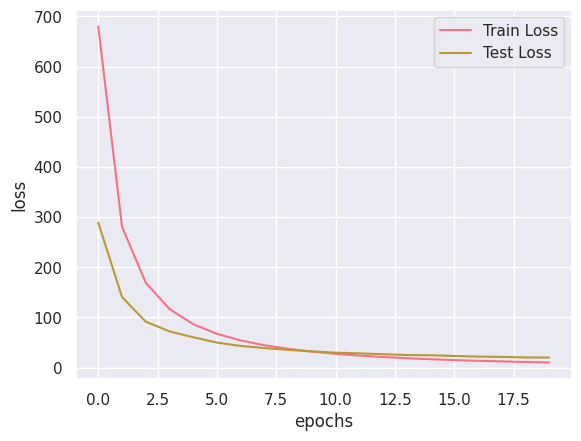

In [ ]:
sns.set()
sns.set_palette("husl")
sns.lineplot(tf.stack(train_loss_plot).numpy(), label="Train Loss")
sns.lineplot(tf.stack(test_loss_plot).numpy(), label="Test Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
files.download('checkpoint')
files.download('ckpt-4.data-00000-of-00001')
files.download('ckpt-4.index')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Beam Search

In [ ]:
def evaluate(image, beam_index = 7):

    start = [tokenizer.word_index['<start>']]
    
    # result[0][0] = index of the starting word
    # result[0][1] = probability of the word predicted
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:

          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

          attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
          i=i+1
          # Getting the top <beam_index>(n) predictions
          word_preds = np.argsort(predictions[0])[-beam_index:]

          
          # creating a new list so as to put them via the model again
          for w in word_preds:       
            next_cap, prob = s[0][:], s[1]
            next_cap.append(w)
            prob += predictions[0][w]
            temp.append([next_cap, prob])
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]


        
        predicted_id = result[-1] # with Max Probability
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
          dec_input = tf.expand_dims([prd_id], 0)  # Decoder input is the word predicted with highest probability among the top_k words predicted
        else:
          break

    result = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)            
        else:
            break
    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption,attention_plot

Visualize Attention on Images

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Play!!!!

[['lone', 'person', 'stand', 'rock', 'large', 'snowy', 'mountain', 'background'], ['A', 'man', 'stand', 'rocky', 'ground', 'front', 'mountain'], ['A', 'man', 'stand', 'front', 'icy', 'mountain'], ['A', 'person', 'stand', 'water', 'front', 'snow', 'top', 'mountain'], ['A', 'traveller', 'pause', 'front', 'mountain', 'view']]
['a', 'man', 'stand', 'front', 'rise', 'rock', 'formation', 'background']
BLEU score: 62.5
time took to Predict: 2 sec


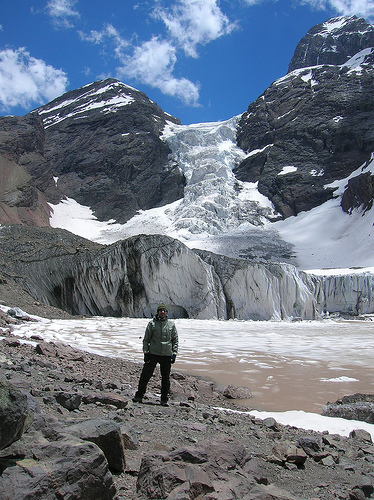

In [ ]:

test_images = df[df['split']=='Test']['Image'].unique()
test_image = random.choice(test_images)
real_captions = df[df['Image'] == test_image]['Caption']

start = time.time()
result, attention_plot = evaluate(flickr_images_dir + test_image)
# plot_attention(flickr_images_dir + test_image, result.split(" "), attention_plot)

captions_list = []
for caption in real_captions:
    captions_list.append(caption.split()[1:-1])

predicted_caption = result.split()

print(captions_list)
print(predicted_caption)

score = sentence_bleu(captions_list, predicted_caption, weights=(1, 0, 0, 0))
print(f"BLEU score: {score*100}")

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(flickr_images_dir+test_image)



In [ ]:
warnings.filterwarnings("ignore")

#TODO: Parallelize Predictions through batching
def makePredictions():
    images = df[df['split'] == 'Test']['Image'].unique()
    predictions = []
    for i, image in enumerate(images):       
        real_captions = df[df['Image'] == image]['Caption']
        split = df[df['Image'] == image]['split'].iloc[-1]
        start = time.time()
        result, _ = evaluate(flickr_images_dir + image)
        end = time.time()

        captions_list = []
        for caption in real_captions:
            captions_list.append(caption.split()[1:-1])
        predicted_caption = result.split()
        score = sentence_bleu(captions_list, predicted_caption, weights=(1, 0, 0, 0))
        predictions.append(
            {
            "Image": image,
            "Split": split,
            "Predicted Caption": ' '.join(predicted_caption),
            "Sample True Caption": real_captions.iloc[-1],
            "BLEU Score": score * 100,
            "Prediction Time(s)": round(end-start)
            }
        )
        if (i+1) % 500 == 0:
            print(f"{datetime.now()}: {i+1}/{len(images)} predicted")
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv("predictions.csv", index=False)
    files.download("predictions.csv")

makePredictions()

In [ ]:

class StepImage():
  def __init__(self, orig_input, step_size=2, 
               renorm=True, eps=30, norm_update='l2'):
    self.orig_input = orig_input
    self.eps = eps
    self.renorm = renorm
    self.step_size = step_size
    self.norm_update = norm_update
    
  def project(self, x):
    """
    """
    orig_feature = feature_model(tf.expand_dims(self.orig_input,0))
    orig_feature = tf.reshape(orig_feature, (orig_feature.shape[0], -1, orig_feature.shape[3]))
    self.mean = tf.reduce_mean(orig_feature)
    self.std = tf.math.reduce_std(orig_feature)

    diff = x - orig_feature
    if self.renorm:
      diff_norm = tf.norm(diff, axis=0)
      diff = diff * self.eps / tf.maximum(1.0, diff_norm)
    val_projected = orig_feature + diff
    
    val_projected *= self.std
    val_projected += self.mean
    val_clamped = tf.clip_by_value(val_projected, 0, 1)
    val_clamped -= self.mean
    val_clamped /= self.std
    return val_clamped
  
  def step(self, x, g):
    step_size = self.step_size
    # Scale g so that each element of the batch is at least norm 1
    if self.norm_update == 'l2':
      g_norm = tf.norm(tf.reshape(g, [tf.shape(g)[0], -1]), axis=1, keepdims=True)
    else:
      g_norm = tf.reduce_mean(tf.abs(g))
    scaled_g = g / (g_norm + 1e-10)
    stepped = x + scaled_g * step_size
    projected = self.project(stepped)
    # print(projected.shape)
    return projected


In [ ]:
def generate_adversarial_example(image, target, n_iter=200):

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    for i in tqdm(range(n_iter)):

        loss = 0

        # initializing the hidden state for each batch
        # because the captions are not related from image to image
        hidden = decoder.reset_state(batch_size=1)      

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

        with tf.GradientTape() as tape:

            tape.watch(img_tensor_val)

            for i in range(1, target.shape[1]):
                # passing the features through the decoder   
                features = encoder(img_tensor_val) 
                    
                predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
                
                # predictions : (64,8329)
                loss += loss_function(target[:, i], predictions)
                # print(loss)
                
                predicted_id = tf.argmax(predictions[0])
                dec_input = tf.expand_dims([predicted_id], 1)

        # print(img_tensor_val)  

        gradient = tape.gradient(loss, img_tensor_val)

        # print(gradient)

        img_tensor_val = step.step(img_tensor_val, -1 * gradient)
      
    
    return img_tensor_val


In [ ]:
target = create_dataset([img_name_train[0]], [train_caption_vector[0]], 1)

for (img_tensor, target) in target.take(1):
    wrong_image = img_tensor
    wrong_target = target

# This allows to backpropagate the image

starting_image, _ = load_image(flickr_images_dir+test_image)
starting_feature = feature_model(tf.expand_dims(starting_image,0))
starting_feature = tf.reshape(starting_feature, (starting_feature.shape[0], -1, starting_feature.shape[3]))
print(starting_feature.shape)

# batch_tensor = starting_image.numpy().copy()

# batch_tensor = tf.Variable(batch_tensor, dtype=tf.float32)

# This updates the image according to some gradient
step = StepImage(starting_image, step_size=3, renorm=True)
batch_tensor = generate_adversarial_example(flickr_images_dir+test_image, wrong_target)


(1, 49, 512)


100%|██████████| 200/200 [02:37<00:00,  1.27it/s]


In [ ]:
np.sqrt(np.sum(np.square(batch_tensor-starting_feature))/(49*512))

9.234923442310263

In [ ]:
def evaluate_feature(img_tensor_val, beam_index = 7):

    start = [tokenizer.word_index['<start>']]
    
    # result[0][0] = index of the starting word
    # result[0][1] = probability of the word predicted
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:

          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

          attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
          i=i+1
          # Getting the top <beam_index>(n) predictions
          word_preds = np.argsort(predictions[0])[-beam_index:]
          
          # creating a new list so as to put them via the model again
          for w in word_preds:       
            next_cap, prob = s[0][:], s[1]
            next_cap.append(w)
            prob += predictions[0][w]
            temp.append([next_cap, prob])
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
       
        predicted_id = result[-1] # with Max Probability
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
          dec_input = tf.expand_dims([prd_id], 0)  # Decoder input is the word predicted with highest probability among the top_k words predicted
        else:
          break

    result = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)            
        else:
            break
    attention_plot = attention_plot[:len(result), :]
    
    return final_caption[1:]

In [ ]:
adv_pred = evaluate_feature(batch_tensor)
pred = [tokenizer.index_word[i] for i in train_caption_vector[0]]
wrong_pred = [word for word in pred if word not in ['<start>', '<end>', '<pad>'] ]
true_pred = evaluate_feature(starting_feature)

In [ ]:
true_pred

['a', 'man', 'stand', 'front', 'rise', 'rock', 'formation', 'background']

In [ ]:
adv_pred

['a',
 'small',
 'blue',
 'shirt',
 'hold',
 'large',
 '<unk>',
 'blue',
 'shirt',
 'hold',
 'large',
 '<unk>',
 'blue',
 'shirt',
 'hold',
 'large',
 '<unk>',
 'blue',
 'shirt',
 'hold',
 'large',
 '<unk>',
 'blue']

In [ ]:
sentence_bleu(captions_list, adv_pred, weights=(1, 0, 0, 0))*100

4.3478260869565215

In [ ]:
sentence_bleu(captions_list, true_pred, weights=(1, 0, 0, 0))*100

62.5

In [ ]:
sentence_bleu(captions_list, wrong_pred, weights=(1, 0, 0, 0))*100

10.000000000000002